### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [27]:
class MyDecisionTreeClassifier: 
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None,
                 sufficient_share=1.0, criterion='gini',
                 max_features=None):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print('invalid criterion name')
            raise


        self.get_feature_ids = self.__get_feature_ids_N

    def __gini_F(self, l_c, r_c):
        return (-(l_c / (l_c + r_c)) ** 2
                - (r_c / (l_c + r_c)) ** 2 + 1)

    def __entropy_F(self, l_c, r_c):
        return (-(l_c / (l_c + r_c)) * np.log2(l_c / (l_c + r_c))
                - (r_c / (l_c + r_c)) * np.log2(r_c / (l_c + r_c)))

    def __misclass_F(self, l_c, r_c):
        return 1 - np.maximum(l_c / (l_c + r_c), r_c / (l_c + r_c))

    def __gini(self, l_c, l_s, r_c, r_s):
        return (self.__gini_F(l_c, r_c)
                - l_c / (l_c + r_c) * self.__gini_F(l_s, -l_s + l_c)
                - r_c / (l_c + r_c) * self.__gini_F(r_s, -r_s + r_c))

    def __entropy(self, l_c, l_s, r_c, r_s):
        return (self.__entropy_F(l_c, r_c)
                - l_c / (l_c + r_c) * self.__entropy_F(l_s, l_c - l_s)
                - r_c / (l_c + r_c) * self.__entropy_F(r_s, r_c - r_s))

    def __misclass(self, l_c, l_s, r_c, r_s):
        return (self.__misclass_F(l_c, r_c)
                - l_c / (l_c + r_c) * self.__misclass_F(l_s, l_c - l_s)
                - r_c / (l_c + r_c) * self.__misclass_F(r_s, r_c - r_s))

    def __get_feature_ids_N(self, n_feature):
        feature_ids = np.array(range(n_feature))
        #np.random.shuffle(feature_ids)
        return feature_ids

    def __sort_samples(self, x, y):
        sorted_idx = x.argsort(axis=1)
        return np.sort(x, axis=1), y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        sort_out = y[0]
        x = x.T
        s_x, s_y = self.__sort_samples(x, y)
        s_y = (s_y == sort_out).astype(int)
        b = np.bincount(s_y[0])
        l_sums = np.cumsum(s_y, axis=1)
        r_sums = b[1] - l_sums
        length = s_y.shape[1]
        l = np.array(range(length))
        l_c = np.array(l + np.zeros(s_y.shape[0]).reshape(-1, 1))
        l_c[:, 0] += 1
        r_c = -l_c + length
        g_matr = self.G_function(l_c, l_sums, r_c, r_sums)
        ind = np.unravel_index(np.argmax(g_matr, axis=None), g_matr.shape)
        try:
            return ((s_x[ind[0], ind[1]] + s_x[ind[0], ind[1] + 1]) / 2.0, 
                    ind[0], g_matr[ind[0], ind[1]])
        except IndexError:
            return s_x[ind[0], ind[1]], ind[0], g_matr[ind[0], ind[1]]

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        y1, c = np.unique(y, return_counts=True)
        y1.sort()
        prob = c / y.size
        y1 = y1[(-c).argsort()]
        if (depth == self.max_depth) or (y.size < self.min_samples_split):
            self.tree[node_id] = (self.__class__.LEAF_TYPE, y1[0], prob)
        elif np.any(prob >= self.sufficient_share):
            self.tree[node_id] = (self.__class__.LEAF_TYPE, y1[0], prob)
        else:
            threshold, feature_id, crit = self.__find_threshold(x, y)
            self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, feature_id, threshold)
            xl, xr, yl, yr = self.__div_samples(x, y, feature_id, threshold)
            if yl.size > 0 and yr.size > 0:
                self.feature_importances_[feature_id] += y.size * crit / self.fit_count
                self.__fit_node(xl, yl, 2 * node_id + 1, depth + 1)
                self.__fit_node(xr, yr, 2 * node_id + 2, depth + 1)
            else:
                self.tree[node_id] = (self.__class__.LEAF_TYPE, y1[0], prob)

    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.features_ids = self.get_feature_ids(x.shape[1])
        self.num_class = np.unique(y).size
        self.fit_count = x.shape[0]
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0)

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [35]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [36]:
np.random.seed(222)

In [37]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [38]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [39]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

1.0

In [40]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

1.0

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [41]:
%time clf.fit(X_train, y_train)

CPU times: user 1.58 ms, sys: 817 µs, total: 2.39 ms
Wall time: 1.49 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [42]:
%time my_clf.fit(X_train, y_train)

CPU times: user 9.48 ms, sys: 2.3 ms, total: 11.8 ms
Wall time: 10.1 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [120]:
df = pd.read_csv('./data/Speed Dating Data.csv', encoding='latin1')
df = df.iloc[:, :97]
df = df.drop(['id'], axis=1)
df = df.drop(['from'], axis=1)
df = df.drop(['idg'], axis=1)
df = df.drop(['condtn'], axis=1)
df = df.drop(['round'], axis=1)
df = df.drop(['wave'], axis=1)
df = df.drop(['position', 'positin1'], axis=1)
df = df.drop(['order'], axis=1)
df = df.drop(['partner'], axis=1)
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)
df = df.dropna(subset=['age'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df = df.drop(['field'], axis=1)
df = df.drop(['undergra'], axis=1)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df['mn_sat'] = df['mn_sat'].fillna(value=0.0)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.loc[:, 'zipcode'] = df.loc[:, 'zipcode'].str.replace(',', '').astype(np.float)
df['tuition'] = df['tuition'].fillna(value=0.0)
df = df.dropna(subset=['imprelig', 'imprace'])
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df['income'] = df['income'].fillna(value=0.0)
df = df.dropna(subset=['date'])
df = df.drop(['career'], axis=1)
df['career_c'] = df['career_c'].fillna(value=0.0)
df = df.drop(['sports','tvsports','exercise','dining',
              'museums','art','hiking','gaming',
              'clubbing','reading','tv','theater','movies',
              'concerts','music','shopping','yoga'], axis=1)
df = df.drop(['expnum'], axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 
                                        'intel1_1', 'fun1_1', 
                                        'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1',
            'intel1_1', 'fun1_1', 
            'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1',
                                        'intel2_1', 'fun2_1',
                                        'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1',
           'intel2_1', 'fun2_1',
           'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1',
            'intel2_1', 'fun2_1',
            'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis=1)
df = df.dropna()
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'
df = df_male.join(df_female)
df = df.fillna(value=0)

X_df = df.drop(['match'], axis=1)
y_df = df['match']
X = np.array(X_df)
y = np.array(y_df)
X, y

(array([[ 2.45e+02,  2.34e+02,  5.00e-02, ...,  0.00e+00,  0.00e+00,
          0.00e+00],
        [ 2.45e+02,  2.35e+02,  4.30e-01, ...,  0.00e+00,  0.00e+00,
          0.00e+00],
        [ 2.45e+02,  2.36e+02,  1.90e-01, ...,  0.00e+00,  0.00e+00,
          0.00e+00],
        ...,
        [ 5.52e+02,  5.28e+02, -4.60e-01, ...,  0.00e+00,  0.00e+00,
          0.00e+00],
        [ 5.52e+02,  5.29e+02,  6.20e-01, ...,  0.00e+00,  0.00e+00,
          0.00e+00],
        [ 5.52e+02,  5.30e+02,  1.00e-02, ...,  0.00e+00,  0.00e+00,
          0.00e+00]]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [122]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [123]:
my_clf.fit(X_train, y_train)

In [124]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [125]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.4980578055964654

In [126]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.5141969831410825

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [61]:
kf=KFold(4)

In [62]:
res=0
for train, test in kf.split(X):
    my_clf2 = MyDecisionTreeClassifier(min_samples_split=2,criterion='entropy')
    my_clf2.fit(X[train],y[train])
    y_p=my_clf2.predict(X[test])
    res+=accuracy_score(y_p,y[test])
res/=5
res

/Users/Denis/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log2
/Users/Denis/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in multiply
/Users/Denis/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log2
/Users/Denis/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log2
/Users/Denis/opt/anaconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply


0.6784708249496982

In [63]:
res=0
for train, test in kf.split(X):
    my_clf2 = MyDecisionTreeClassifier(min_samples_split=2,criterion='gini')
    my_clf2.fit(X[train],y[train])
    y_p=my_clf2.predict(X[test])
    res+=accuracy_score(y_p,y[test])
res/=5
res

0.6378269617706238

In [64]:
res=0
for train, test in kf.split(X):
    my_clf2 = MyDecisionTreeClassifier(min_samples_split=2,criterion='misclass')
    my_clf2.fit(X[train],y[train])
    y_p=my_clf2.predict(X[test])
    res+=accuracy_score(y_p,y[test])
res/=5
res

0.6209255533199196

In [127]:
results=[]
for depth in range(1,40):
    res=0
    for train, test in kf.split(X):
        my_clf = MyDecisionTreeClassifier(max_depth=depth,criterion='gini')
        my_clf.fit(X[train],y[train])
        y_p=my_clf.predict(X[test])
        res+=accuracy_score(y_p,y[test])       
    res/=4
    results.append(res)

In [128]:
max(results)

0.8501006036217303

In [130]:
b_depth = 4
b_crit = 'gini'

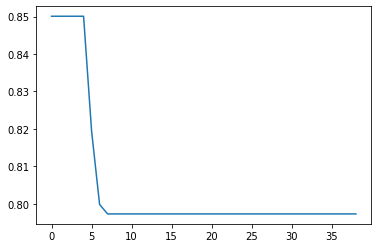

In [129]:
plt.plot(results) 

In [131]:
results_spl=[]
for split in range(2,50):
    res=0
    for train, test in kf.split(X):
        my_clf = MyDecisionTreeClassifier(max_depth=4, min_samples_split=split,criterion='gini')
        my_clf.fit(X[train],y[train])
        y_p=my_clf.predict(X[test])
        res+=accuracy_score(y_p,y[test])       
    res/=4
    results_spl.append(res)

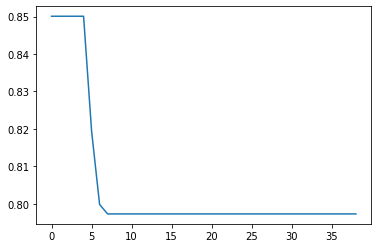

In [132]:
plt.plot(results) 

In [105]:
b_split = 2

In [172]:
my_clf = MyDecisionTreeClassifier(max_depth=20, min_samples_split=2,criterion='gini')

In [173]:
my_clf.fit(X_train, y_train)

In [174]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.5141969831410825

In [175]:
clf = DecisionTreeClassifier(max_depth=20, min_samples_split=2, criterion='gini')

In [176]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [177]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.5022908984703005

Не понимаю, почему такой скор маленький

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [178]:
my_clf.feature_importances_

array([0.12724651, 0.16227639, 0.17767719, 0.03353002, 0.02347433,
       0.02335139, 0.03207626, 0.08717406, 0.02614901, 0.08463696,
       0.        , 0.00593734, 0.        , 0.03308306, 0.01001001,
       0.31192396, 0.02904769, 0.03608788, 0.00939212, 0.02523369,
       0.01189056, 0.        , 0.        , 0.16150218, 0.10682782,
       0.02845743, 0.05282765, 0.        , 0.0288417 , 0.        ,
       0.05330645, 0.10024224, 0.05943635, 0.        , 0.0299108 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Немного не понимал, как прогать эту модель. Подсмотрел немного структуру из прошлого семестра.